# Dataset

This notebook visualizes and analyzes the collected PQC dataset

### Imports

In [6]:
import pandas as pd
import numpy as np
from JQCLib.Plotting.Plots import CorrelationHeatmap, CrossEntropyCompare, cpPlot
from JQCLib.Preprocessing.Utils import thesisData
import seaborn as sns
from matplotlib import pyplot as plt
from qiskit.visualization import array_to_latex as latex
from scipy import stats
plt.rcParams["figure.figsize"] = (12, 6)

### Helper functions

In [7]:
#Swap Pandas dataframe columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

### Dataset

In [23]:
#Datafile with complete metrics
#-------------------------------------------
DATAFILE = 'JQCLib\\Results\\PQC_Dataset.csv'
#-------------------------------------------

#Load Pandas dataframe and drop 'Frame Potential' columns
ds = thesisData(DATAFILE).drop(['FP1', 'FP2'], axis=1)

#Rename some columns
ds = ds.rename(columns={'CrossEntropy':'Cross Entropy','DKL': 'KL Divergence','Meyer Wallach':'Meyer-Wallach'})

#Swap columns 8 & 9 : Meyer Wallach and DKL
ds = swap_columns(ds, 'Meyer-Wallach', 'KL Divergence')

#Index of labels that should be included in "all metrics"
labelIdx = [0,1,2,7,8,9]
MetricNames = [ds.columns[idx] for idx in labelIdx]

#Print head of Pandas dataframe
ds.head()

,Number of gates,Parameterized gates,Non-local gates,Training time,Training iterations,Cross Entropy,Accuracy,Hilbert-Schmidt norm,KL Divergence,Meyer-Wallach
Id,,,,,,,,,,
182,25,11,12,1294.738940,65,0.785542,0.666667,0.128597,0.183884,0.971907
183,30,15,9,1264.979127,85,0.509337,0.866667,0.136123,0.277736,0.946984
184,30,13,12,342.593349,25,0.736767,0.800000,0.283129,0.490936,0.904826
185,29,13,11,305.047179,20,0.781006,0.733333,0.135145,0.253976,0.930992
186,25,13,10,1081.279061,50,0.670371,0.866667,0.132347,0.192846,0.934301


### Normaltest data columns

In [25]:
for i in [0,1,2,4,5,6]:
    name = ds.columns[i]
    nd = stats.normaltest(ds[name])
    ndlbl = "Yes"
    if(nd.pvalue < 0.05):
        ndlbl = "No"
    print(name,np.round(nd.statistic,3),np.round(nd.pvalue,3),ndlbl)

Number of gates 0.255 0.88 Yes
Parameterized gates 74.592 0.0 No
Non-local gates 6.232 0.044 No
Training iterations 8778.201 0.0 No
Cross Entropy 945.911 0.0 No
Accuracy 372.149 0.0 No


In [26]:
ds.nsmallest(10, 'Cross Entropy')
#ds[ds["Accuracy"]==1.0]

,Number of gates,Parameterized gates,Non-local gates,Training time,Training iterations,Cross Entropy,Accuracy,Hilbert-Schmidt norm,KL Divergence,Meyer-Wallach
Id,,,,,,,,,,
3580,30,18,9,2704.388900,83,0.246915,0.933333,0.133539,0.105288,0.889957
3005,30,16,9,1346.195611,48,0.251433,1.000000,0.124054,0.270505,0.936895
7689,26,11,12,1144.512194,53,0.270417,1.000000,0.285439,0.461826,0.885195
6414,25,12,12,829.103370,95,0.284565,1.000000,0.126048,0.090824,0.855303
5613,30,15,10,698.835881,48,0.286900,0.933333,0.149197,0.074886,0.940956
1828,29,14,12,1832.864622,58,0.290258,0.933333,0.286824,0.527455,0.966300
347,29,14,11,741.491579,49,0.292882,0.933333,0.132586,0.082529,0.978024
441,26,15,9,1102.266315,80,0.294276,1.000000,0.132262,0.074085,0.890169
842,30,18,8,3516.521187,120,0.303433,1.000000,0.124483,0.067478,0.939565


### Correlation

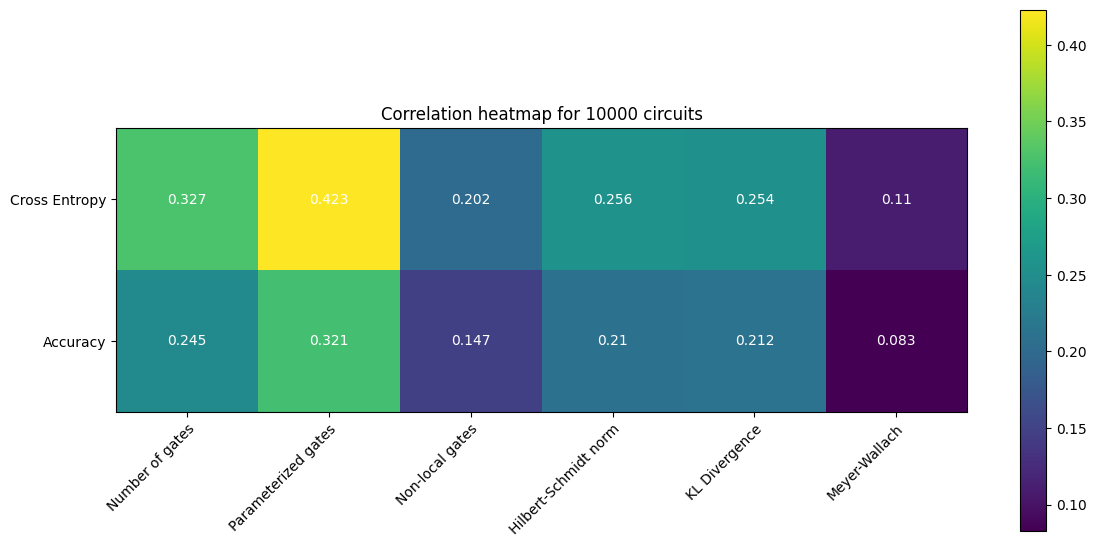

In [15]:
scoreColumns = ["Cross Entropy", "Accuracy"]
CorrelationHeatmap(ds,MetricNames,scoreColumns)

In [16]:
def PearsSpear(data,metric):
    pears = np.round(ds[data].corr(ds[metric]),3)
    spear = np.round(stats.spearmanr(ds[data],ds[metric]).statistic,3)
    return pears,spear

for s in scoreColumns:
    for m in MetricNames[3:]:   
        print(m,"with",s,*PearsSpear(m,s))

print("---------------------------")
m = 'Hilbert-Schmidt norm'
s = 'KL Divergence'
print(m,"with",s,*PearsSpear(m,s))

Hilbert-Schmidt norm with Cross Entropy 0.256 0.165
KL Divergence with Cross Entropy 0.254 0.388
Meyer-Wallach with Cross Entropy -0.11 -0.065
Hilbert-Schmidt norm with Accuracy -0.21 -0.13
KL Divergence with Accuracy -0.212 -0.284
Meyer-Wallach with Accuracy 0.083 0.046
---------------------------
Hilbert-Schmidt norm with KL Divergence 0.71 0.404


### Compare CrossEntropy of best model (per gate count) to model with best (given) metric

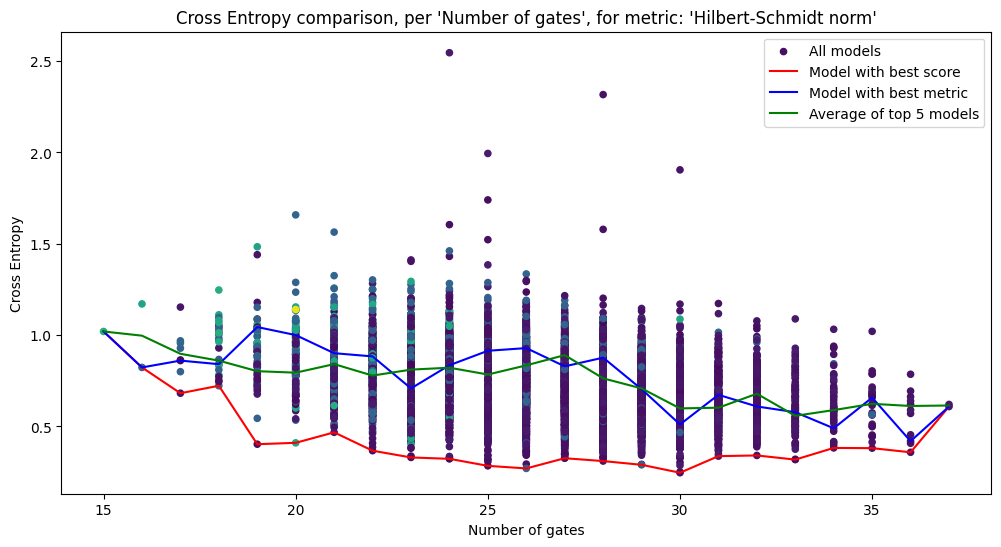

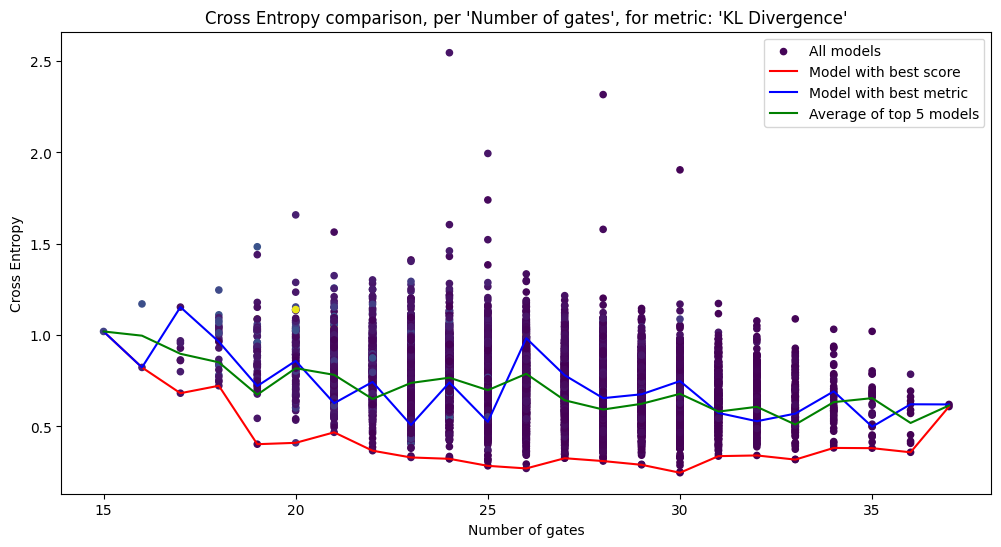

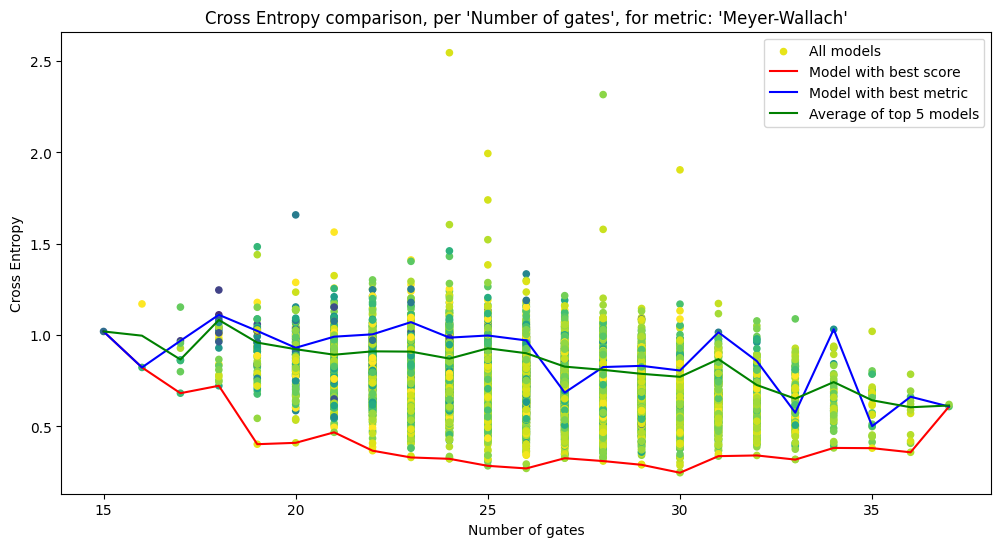

In [17]:
#Iterate metric names, starting with 'Hilbert-Schmidt norm'
for idx in range(7,len(ds.columns)):    
    CrossEntropyCompare(ds, ds.columns[idx])

### Plot all features against CrossEntropy, colored by 'Number of gates'

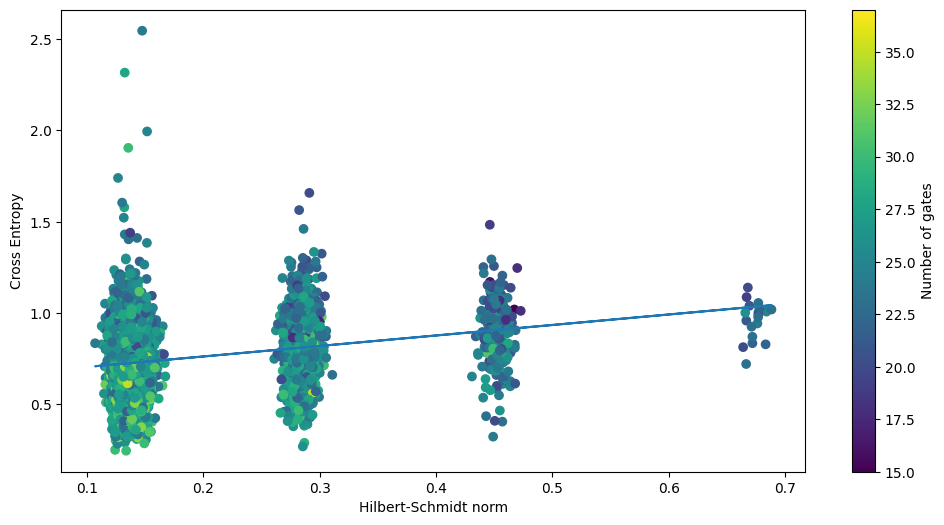

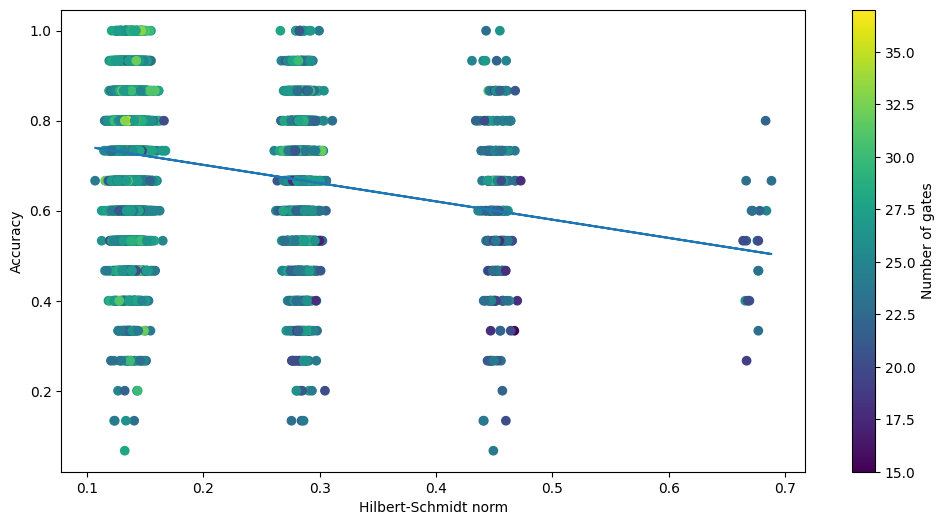

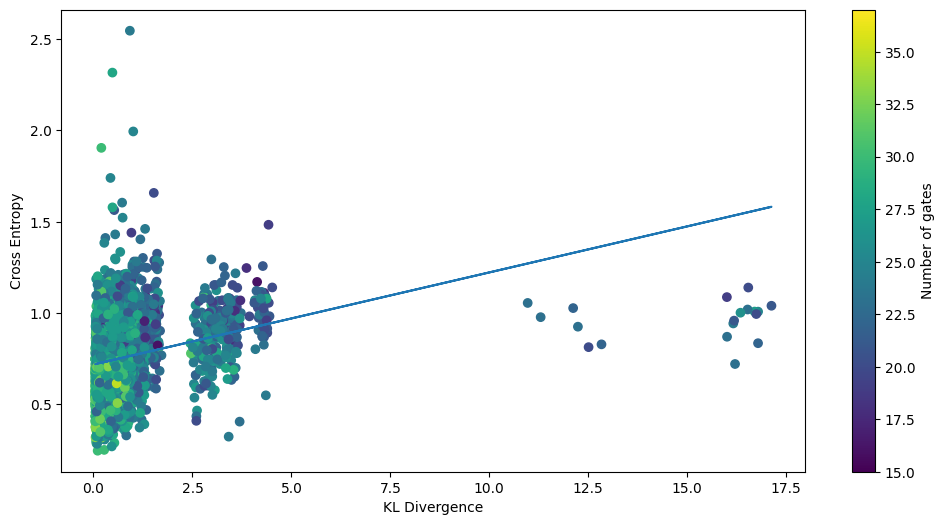

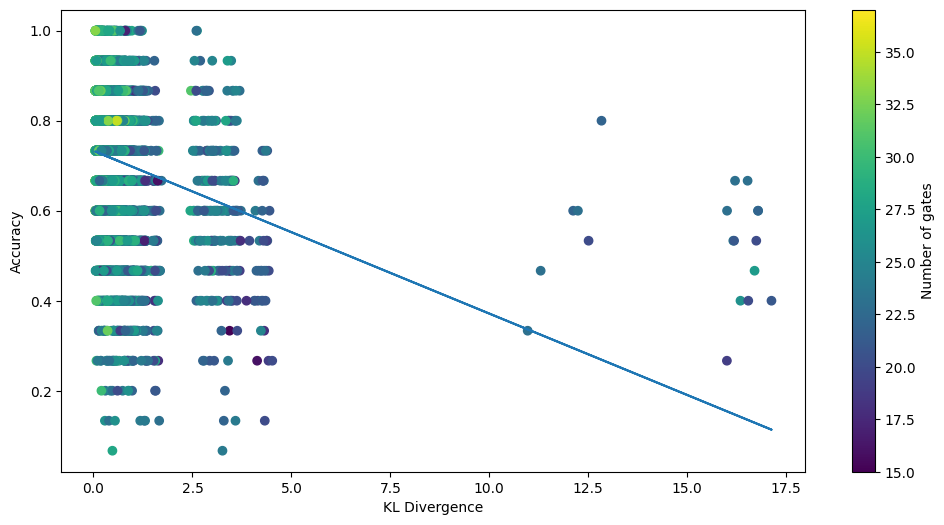

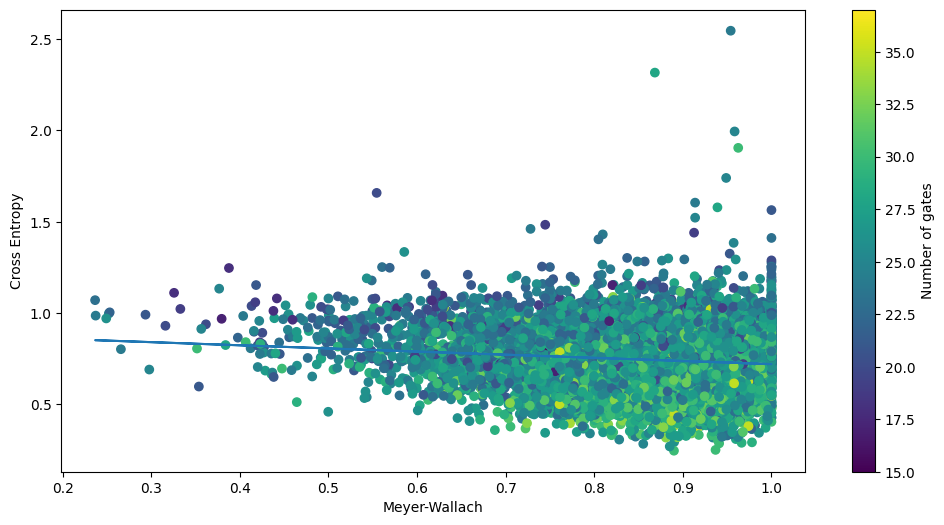

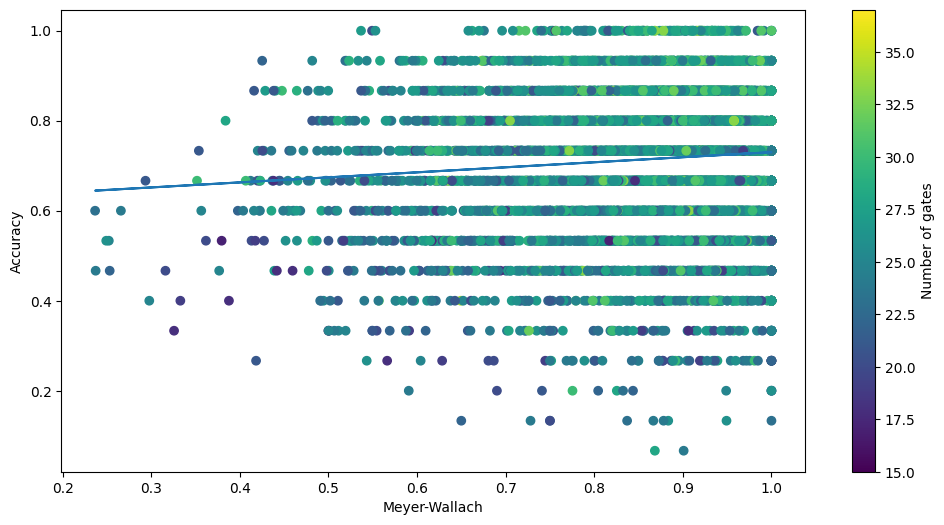

In [18]:
for idx in labelIdx[-3:]:
    cpPlot(ds, ds.columns[idx], "Cross Entropy","Number of gates")
    cpPlot(ds, ds.columns[idx], "Accuracy","Number of gates")

### Plot 'Parameterized gates' against binned 'Training time'

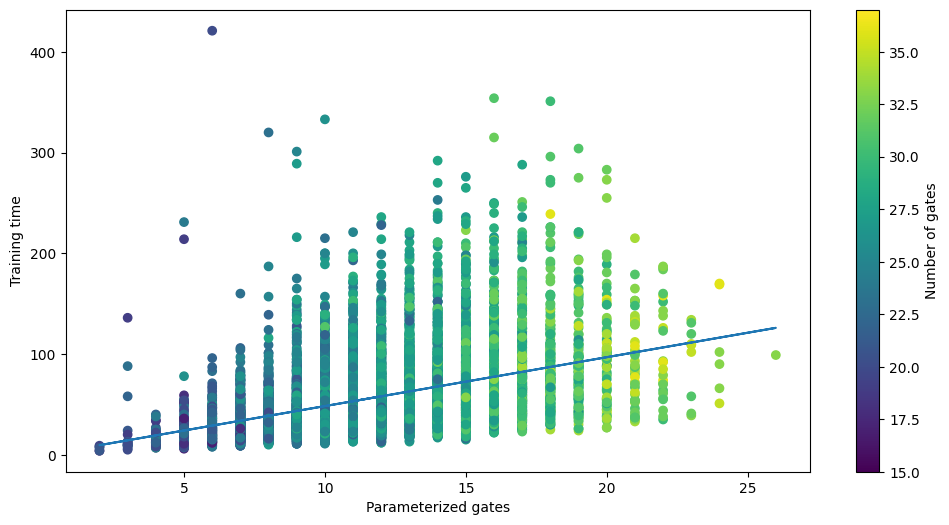

In [19]:
w = "Parameterized gates"
t = "Training time"
c = "Number of gates"
cpPlot(ds, w, t, c, bin=10)

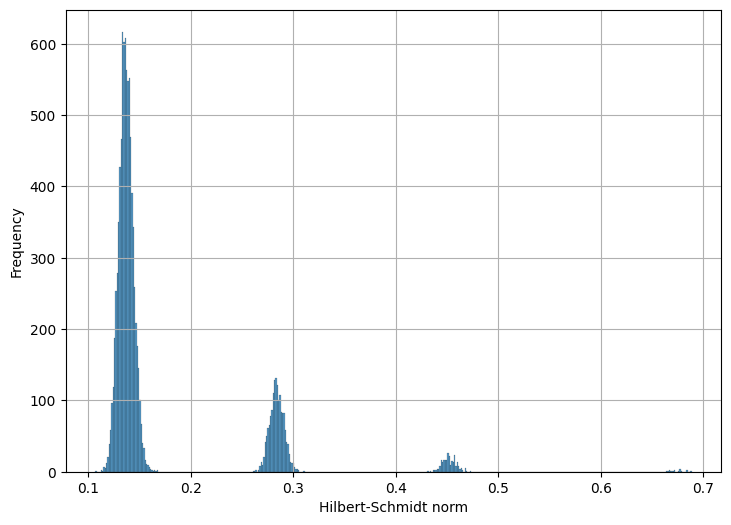

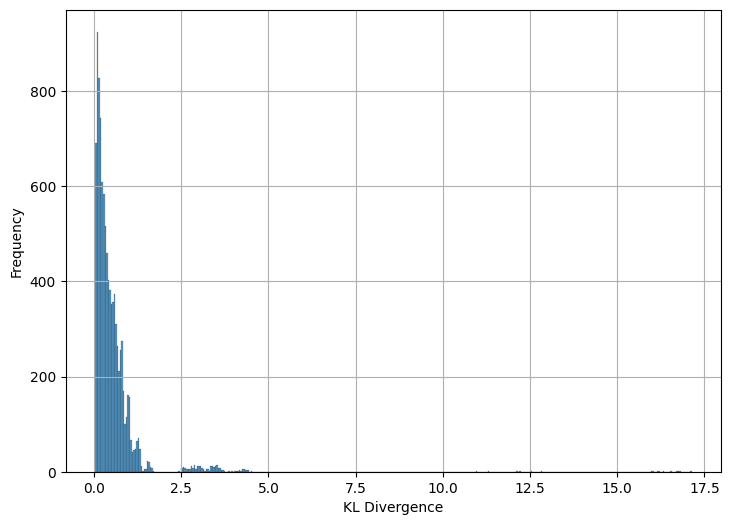

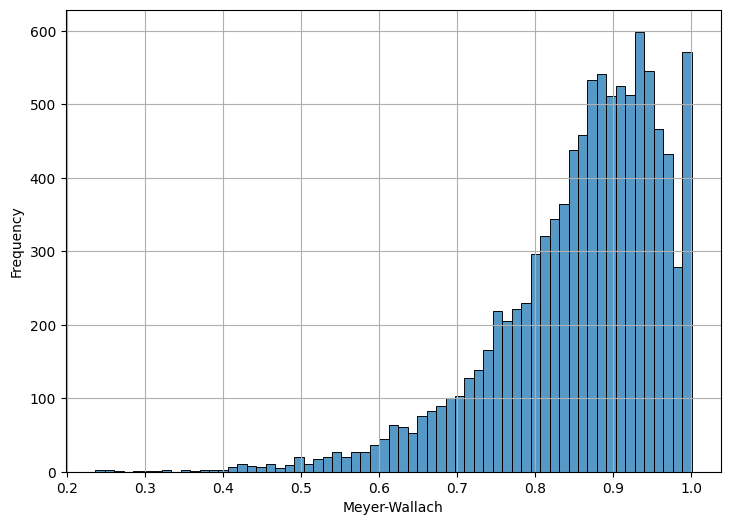

In [20]:
def discretePlot(name):    
    sns.histplot(data=ds, x=name, discrete=True)
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def snsplot(name, useUnique = False):    
    if(useUnique):        
        #sns.histplot(data=ds, x=name,bins=len(ds[name].unique()), kde=True)        
        sns.histplot(data=ds, x=name, kde=False)        
    else:
        sns.histplot(data=ds, x=name, kde=False)
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plt.rcParams["figure.figsize"] = (6*1.41, 6)
snsplot('Hilbert-Schmidt norm')
snsplot('KL Divergence')
snsplot('Meyer-Wallach')

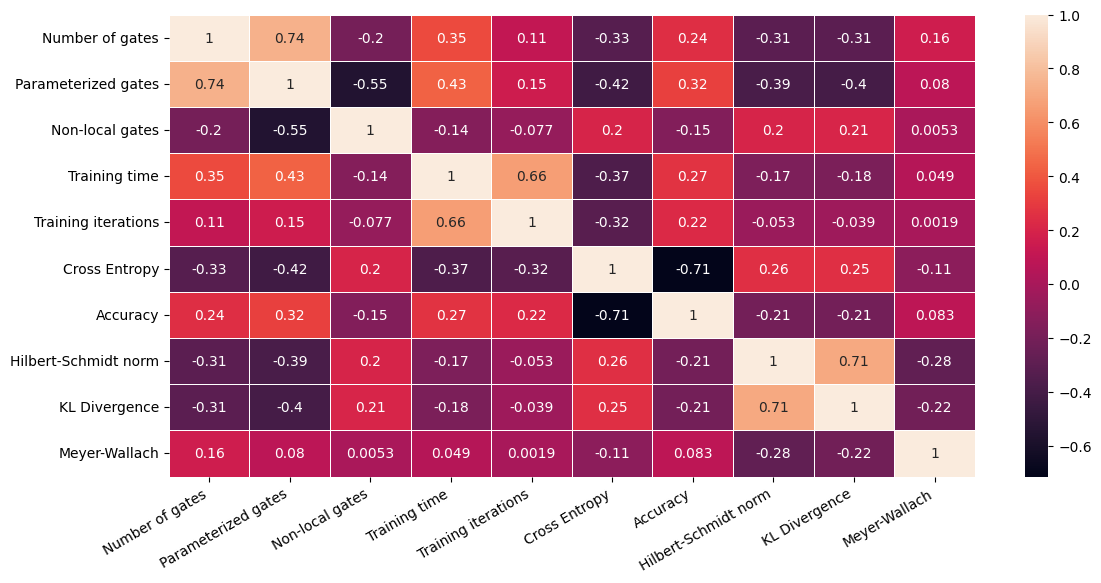

In [21]:
plt.figure(figsize=(13, 6))
sns.heatmap(ds.corr(), vmax=1, annot=True, linewidths=.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()